In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np

In [2]:
img_idx = 100

In [3]:
# Load matfile
with h5py.File('./p00.mat', 'r') as f:
    print(f['Data'].keys())
    print(type(f['Data']['data'][img_idx]))

    img = f['Data']['data'][img_idx]
    img = np.transpose(img, (1, 2, 0)).astype(np.uint8)

    # Switch from BGR to RGB
    img = img[:, :, ::-1]

    # Horizontal flip
    img = img[:, ::-1, :]


<KeysViewHDF5 ['data', 'label', 'par_a_h', 'par_a_w', 'par_b_h', 'par_b_w', 'screenPattern', 'screen_height', 'screen_width']>
<class 'numpy.ndarray'>


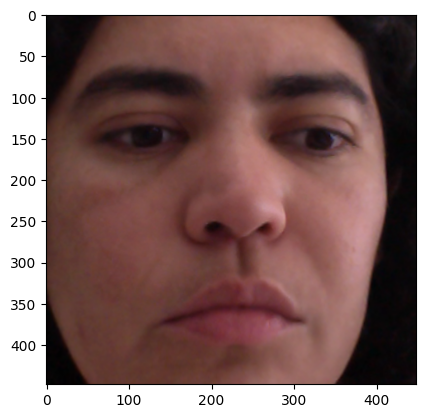

In [4]:
plt.imshow(img)
plt.show()


In [5]:
with h5py.File('./p00.mat', 'r') as f:
    print(f['Data'].keys())
    print(f['Data']['label'][img_idx])

    gaze_vector = f['Data']['label'][img_idx][0:2]
    head_pose_vector = f['Data']['label'][img_idx][2:4]
    landmarks = f['Data']['label'][img_idx][4:16].reshape(6, 2)
    landmarks[:, 0] = 448.0 - landmarks[:, 0]



<KeysViewHDF5 ['data', 'label', 'par_a_h', 'par_a_w', 'par_b_h', 'par_b_w', 'screenPattern', 'screen_height', 'screen_width']>
[-3.0010355e-01  2.9581988e-01  1.4808750e-01  2.1821487e-01
  8.7727379e+01  1.5259277e+02  1.6920987e+02  1.5209787e+02
  2.8643152e+02  1.4930060e+02  3.6996555e+02  1.5154993e+02
  1.3735774e+02  3.7248102e+02  3.0278119e+02  3.7254102e+02]


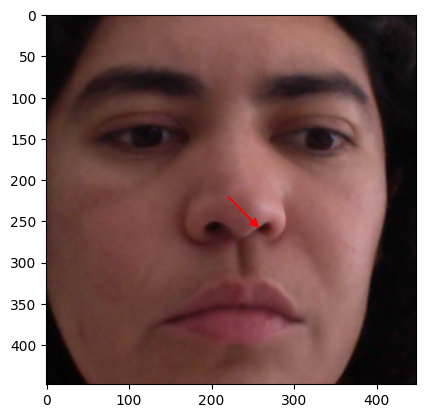

In [6]:
dx = -gaze_vector[0] * 100
dy = gaze_vector[1] * 100

plt.imshow(img)
plt.arrow(220, 220, dy, dx, head_width=10, head_length=10, fc='r', ec='r')
plt.show()

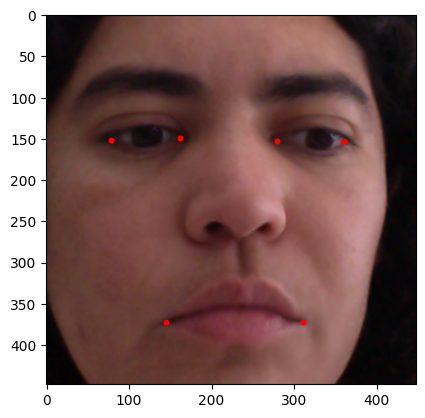

In [7]:
plt.imshow(img)
plt.scatter(landmarks[:, 0], landmarks[:, 1], c='r', s=10)
plt.show()

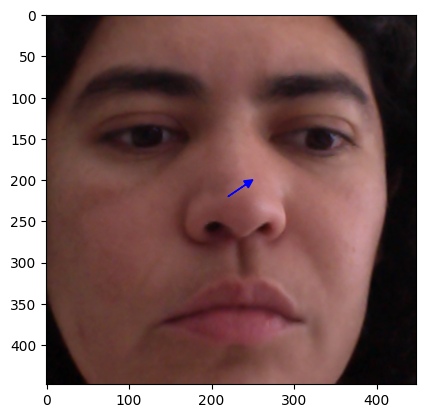

In [8]:
dx = -head_pose_vector[0] * 100
dy = head_pose_vector[1] * 100

plt.imshow(img)
plt.arrow(220, 220, dy, dx, head_width=10, head_length=10, fc='b', ec='b')
plt.show()

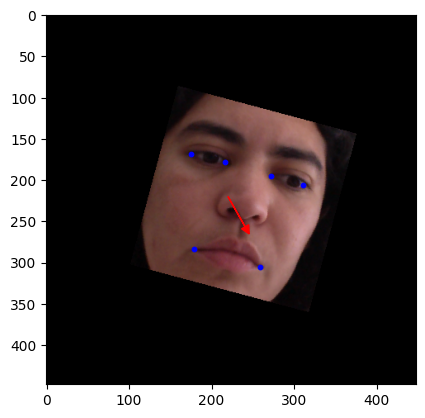

In [18]:
import torch
import torchvision.transforms.functional as TF
import math

img_copy = img.copy()
transformed_img = TF.affine(torch.tensor(img_copy.transpose(2, 0, 1)), angle=15, translate=(15, 0), scale=0.5, shear=(0, 0))

angle_rad = math.radians(15)
cos_a = math.cos(angle_rad)
sin_a = math.sin(angle_rad)

# Gaze
pitch, yaw = gaze_vector[0], gaze_vector[1]
# Convert gaze angles to 3D direction vector
x = -math.cos(pitch) * math.sin(yaw)
y = -math.sin(pitch)
z = -math.cos(pitch) * math.cos(yaw)

# Since we're rotating the image clockwise by 15°, we need to rotate the gaze vector counter-clockwise
x_new = x * cos_a + y * sin_a
y_new = -x * sin_a + y * cos_a
z_new = z

# Convert back to pitch/yaw angles
new_pitch = math.asin(np.clip(-y_new, -1.0, 1.0))
new_yaw = math.atan2(-x_new, -z_new)

# Landmarks
landmarks_copy = landmarks.copy()
landmarks_copy -= 220

landmarks_copy *= 0.5

x_rot = landmarks_copy[:, 0] * cos_a - landmarks_copy[:, 1] * sin_a
y_rot = landmarks_copy[:, 0] * sin_a + landmarks_copy[:, 1] * cos_a
landmarks_copy[:, 0] = x_rot
landmarks_copy[:, 1] = y_rot

landmarks_copy += 220
landmarks_copy[:, 0] += 15

plt.imshow(transformed_img.numpy().transpose(1, 2, 0))
plt.arrow(220, 220, new_yaw * 100, -new_pitch * 100, head_width=10, head_length=10, fc='r', ec='r')
plt.scatter(landmarks_copy[:, 0], landmarks_copy[:, 1], c='b', s=10)
plt.show()